In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder,TargetEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot 
import pdpbox as pdp
import shap

In [116]:
#Merge the years
df1 = pd.read_csv('2015.csv')
df1['Year'] = 2015.0
df2 = pd.read_csv('2016.csv')
df2['Year'] = 2016.0
df3 = pd.read_csv('2017.csv')
df3['Year'] = 2017.0
df4 = pd.read_csv('2018.csv')
df4['Year'] = 2018.0
df = pd.merge(pd.merge(df1,df2,how='outer'),pd.merge(df3,df4,how='outer'),how='outer')

#Create Average
df['Average'] = ((df['Economy'] + df['Generosity'] +
                  df['Family'] + df['Health'] + 
                  df['Freedom'] + df['Trust']))


In [117]:
remove = []
for col in df.columns:
    if df[col].isna().value_counts(normalize=True).loc[False] < .76:
        remove.append(col)
remove.append('Happiness Rank')
df.drop(columns=remove,inplace = True)

# for col in df.columns:
#     print(col,df[col].isna().value_counts(normalize=True).loc[False])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626 entries, 0 to 625
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Happiness Score  626 non-null    float64
 1   Economy          626 non-null    float64
 2   Family           626 non-null    float64
 3   Health           626 non-null    float64
 4   Freedom          626 non-null    float64
 5   Trust            625 non-null    float64
 6   Generosity       626 non-null    float64
 7   Year             626 non-null    float64
 8   sum              625 non-null    float64
dtypes: float64(9)
memory usage: 48.9 KB


In [118]:
target = 'Happiness Score'
X = df.drop(columns = target)
y = df[target]

In [119]:
#Splits 80% 20%
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.2, random_state=9001)
#Splits 80% 10% 10%
X_val, X_test,y_val,y_test = train_test_split(X_val,y_val,test_size=.5, random_state=9002)
#print(len(X_train),len(X_val),len(X_test))

In [120]:
#Linear Regression
model_lr = make_pipeline(
OrdinalEncoder(),
SimpleImputer(),
LinearRegression()
)
model_lr.fit(X_train,y_train);

In [121]:
#Random Forest
model_rf = make_pipeline(
OrdinalEncoder(),
SimpleImputer(),
RandomForestRegressor(max_depth=10,n_jobs=-1,random_state=10)
)
model_rf.fit(X_train,y_train);

In [122]:
#Ridge Regression
model_r = make_pipeline(
OrdinalEncoder(),
SimpleImputer(),
Ridge()
)
model_r.fit(X_train,y_train);

In [123]:
#Boost Regression
model_gb = make_pipeline(
    OrdinalEncoder(), 
    XGBRegressor(n_estimators=20, objective='reg:squarederror', n_jobs=-1,random_state=10)
)
model_gb.fit(X_train, y_train);

In [124]:
print('Linear Regression val',r2_score(y_val, model_lr.predict(X_val)))
print('Linear Regression test',r2_score(y_test, model_lr.predict(X_test)),'\n')

print('Ridge Regression val',r2_score(y_val, model_r.predict(X_val)))
print('Ridge Regression val',r2_score(y_test, model_r.predict(X_test)),'\n')

print('Random Forest val',r2_score(y_val, model_rf.predict(X_val)))
print('Random Forest test',r2_score(y_test, model_rf.predict(X_test)),'\n')

print('XGBoost val',r2_score(y_val, model_gb.predict(X_val)))
print('XGBoost test',r2_score(y_test, model_gb.predict(X_test)))

Linear Regression val 0.796166166969206
Linear Regression test 0.6569363863034334 

Ridge Regression val 0.7957235500401976
Ridge Regression val 0.6582125048889156 

Random Forest val 0.8311815841488186
Random Forest test 0.781487136638491 

XGBoost val 0.8447174725470639
XGBoost test 0.7307260552339243


Text(0, 0.5, 'Happiness')

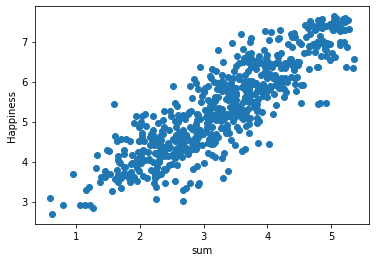

In [126]:
fig, ax_2 = plt.subplots()
ax_2.scatter(df['Average'],df['Happiness Score'])
ax_2.set_xlabel('Average')
ax_2.set_ylabel('Happiness')

<BarContainer object of 8 artists>

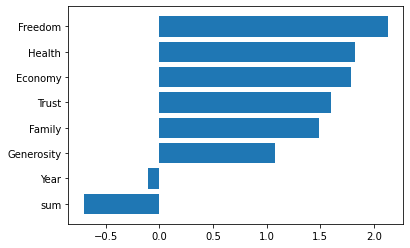

In [125]:
import matplotlib.pyplot as plt
model = model_lr.named_steps['linearregression']

array = pd.DataFrame()
array['coef'] = model.coef_
array['column'] = X.columns
array = array.sort_values(by='coef',ascending=True)

fig, ax = plt.subplots()
ax.barh(array['column'],array['coef'])

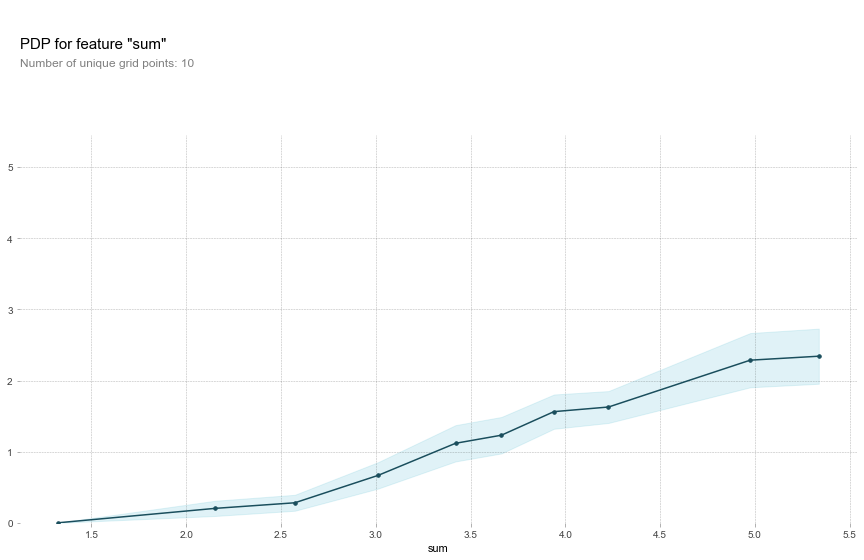

In [127]:
feature = 'Average'

isolate = pdp_isolate(
    model_rf,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

In [128]:
row = X_val.tail(1)

print(row)
explainer = shap.TreeExplainer(model_rf.named_steps['randomforestregressor'])
shap_values = explainer.shap_values(row)

image = shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

     Economy  Family  Health  Freedom  Trust  Generosity    Year    sum
476     1.33   1.532   0.896    0.653  0.291       0.321  2018.0  5.023


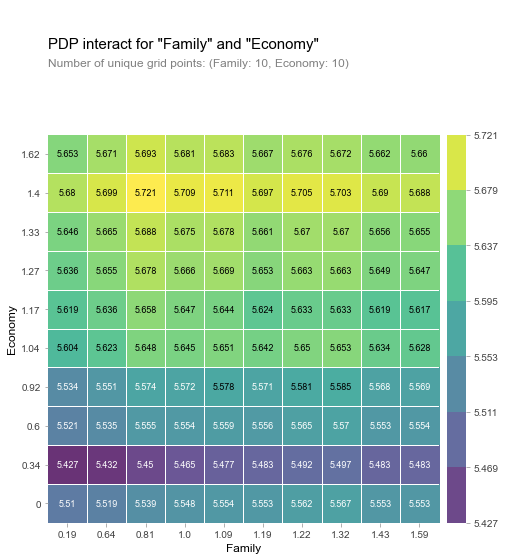

In [129]:
features = ['Family', 'Economy']

interact = pdp_interact(
    model_rf,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interact, plot_type='grid', feature_names=features);